# Results from WandB


## Imports

In [5]:
from community.utils.plotting import set_style
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import json
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
from itertools import product
import ipywidgets as widgets
import os


In [6]:
from community.utils.heatmap import compute_and_plot_heatmap, compute_and_plot_colormesh
from community.data.datasets.mnist import estimate_covariance


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Results

In [8]:
local_save = True


sweep_id = "8svrrgfg"

if not local_save:

    try:
        total_data = pd.read_pickle(f"../../results/sweep_tables/{sweep_id}")
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"../../results/sweep_tables/MetricResults_{sweep_id}"
        )
else:
    try:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{sweep_id}/metric_table"
        )
    except FileNotFoundError:
        total_data = pd.read_pickle(
            f"/mnt/storage/gb21/community/compiled_wandb_results/{sweep_id}/metric_table_safe"
        )
p = total_data["sparsity"]
total_data["q_metric"] = 0.5 * (1 - p) / (1 + p)
total_data["n_conns"] = (
    (total_data["n_hidden"] ** 2 * total_data["sparsity"]).round().astype(int)
)
total_data

metrics = [
    "retraining_det_col_norm",
    "ablations_det_col_norm",
    "correlations_det_col_norm",
]

total_data["mean_global_diff"] = total_data[metrics].mean(1)
# total_data['covariance'] = 1 / total_data['cov_ratio']
total_data["n_classes"] = [
    {"double_digits": 10, "double_letters": 16}[d] for d in total_data["data_type"]
]

covariances = {}
for n in total_data["n_classes"].unique():
    for c in total_data["cov_ratio"].unique():
        covariances[n, c] = estimate_covariance(c, int(n))
total_data["covariance"] = [
    covariances[n, c] for c, n in total_data[["cov_ratio", "n_classes"]].values
]

In [9]:
def filter_data(data, v_params):
    data = data.copy()
    for key, value in v_params.items():
        if isinstance(value, list):
            filter = np.sum([data[key] == v for v in value], axis=0).astype(bool)
            data = data[filter]
        else:
            if value is None:
                data = data[data[key].isnull()]
            else:
                data = data[data[key] == value]

    return data


def get_values(data, x="n_hidden", y="sparsity", value="retraining_global_diff"):
    return data[[x, y, value]].values.T


def get_all_v_params(varying_params, excluded_params={}):
    return [
        {
            k: p
            for k, p in zip(varying_params.keys(), params)
            if k not in excluded_params
        }
        for params in product(*varying_params.values())
    ]


params = ["common_readout", "n_bot", "common_input", "task", "Step", "cov_ratio"]


varying_params = {}
for param in params:
    if param in total_data.columns:
        varying_params[param] = total_data[param].unique().tolist()
        try:
            varying_params[param] = sorted(varying_params[param])
            varying_params[param] = [
                v if not np.isnan(v) else None for v in varying_params[param]
            ]
        except TypeError:
            pass


heatmap_params = ["n_hidden", "sparsity", "cov_ratio", "n_conns"]

In [10]:
total_data["mult"] = total_data["retraining_global_diff"] * total_data["best_acc"]


## Plot Interactive Sweep Results

In [7]:
varying_params_all = get_all_v_params(varying_params)


def plot_fn(**params):

    plot_type = params.pop("plot_type")
    metric = params.pop("metric_to_plot")
    smoothness = params.pop("smoothness")
    log_scale = params.pop("log_scale")
    x, y = params.pop("x"), params.pop("y")

    v_params = {k: v for k, v in params.items()}
    print(v_params)
    # print(v_params)
    excluded_params = {"Step", "task"}
    v_params_filered = {k: v for k, v in params.items() if k not in excluded_params}
    legend_params = {k: v for k, v in v_params_filered.items() if len(v) != 1}

    tasks, steps = v_params["task"], v_params["Step"]

    n_tasks = len(tasks)
    n_steps = len(steps)

    v_params_all = get_all_v_params(v_params_filered)
    legend_params_all = get_all_v_params(legend_params)

    if plot_type == "grad_spec":
        pass

    else:
        for s, step in enumerate(steps):

            v_p1 = len(v_params_filered)
            v_p2 = max([len(v) for v in v_params_filered.values()])

            n_params = len(v_params_all)
            n1 = int(np.sqrt(n_params))
            n2 = n_params // n1

            if n1 * n2 < n_params:
                n2 += 1

            # print(n1, n2)

            fig = plt.figure(
                constrained_layout=True, figsize=(5 * n2, 5 * n1 * n_tasks)
            )

            fig.suptitle(f"Functional Specialization on step {step}")

            # create 3x1 subfigs
            subfigs = fig.subfigures(nrows=n_tasks, ncols=1)
            if n_tasks == 1:
                subfigs = [subfigs]

            Zs = []

            for t, (subfig, task) in enumerate(zip(subfigs, tasks)):

                subfig.suptitle(f"Task :  {task}")

                # create subplots per subfig

                axs = subfig.subplots(nrows=n1, ncols=n2)

                try:
                    axs[0]
                except TypeError:
                    axs = np.array([axs])
                for i, (ax, v_param, l_param) in enumerate(
                    zip(axs.flatten(), v_params_all, legend_params_all)
                ):

                    filter_param = v_param.copy()
                    filter_param["Step"] = step
                    filter_param["task"] = task
                    data = filter_data(
                        total_data[total_data["sparsity"] != 0], filter_param
                    )

                    argmins = (
                        data[metric].values.argsort()[:10],
                        data[metric].values.argsort()[-10:],
                    )
                    minmax = [data[metric].values[idxs].mean() for idxs in argmins]
                    # print(minmax)
                    # print(data.shape)
                    values = get_values(data, x, y, metric)

                    print(data.shape)

                    if 0 not in data.shape:
                        if plot_type == "heatmap":

                            (
                                (X, Y),
                                (X_mesh, Y_mesh),
                                Z,
                                sigmas,
                                *_,
                            ) = compute_and_plot_heatmap(
                                values,
                                (fig, ax),
                                log_scale=log_scale,
                                plot_f=False,
                                random=False,
                                minmax=None,
                                smoothness=smoothness,
                            )
                        elif plot_type == "scipy":
                            (
                                X_mesh,
                                Y_mesh,
                                Z,
                                (fig, ax),
                                cbar,
                            ) = compute_and_plot_colormesh(
                                values, (fig, ax), log_scale=log_scale
                            )

                        elif plot_type == "table":

                            grouped_values = data.groupby([x, y])[metric].mean()

                            x_values = data[x].unique()[::-1]
                            y_values = data[y].unique()
                            y_values_per_x = data.groupby(x)[y].unique()

                            # Z = np.array([[grouped_values[x][y] for y in y_values_per_x[x]] for x in x_values]).T
                            Z = pd.concat([grouped_values[x] for x in x_values], axis=1)
                            Z.columns = x_values

                            # print(Z)

                            im = ax.imshow(Z)
                            ax.set_xticks(range(len(x_values)))
                            ax.set_xticklabels(x_values.astype(str))
                            if y == "cov_ratio":
                                ax.set_yticks(range(len(y_values)))
                                ax.set_yticklabels(y_values.astype(str))
                            ax.set_xlabel(x)
                            ax.set_ylabel(y)
                            fig.colorbar(im, ax=ax)

                        Zs.append(Z)

                    ax.set_title((str(l_param).strip("{}").replace(",", "\n")))

In [8]:
params_widgets = {
    k: widgets.SelectMultiple(
        options=[p for p in params], description=k, disabled=False, value=[params[0]]
    )
    for k, params in varying_params.items()
    if (len(params) > 1 or k == "task")
}

params_widgets["smoothness"] = widgets.FloatSlider(7, min=0.5, max=10, step=0.2)
# params_widgets['epoch'] = widgets.IntSlider(nb_epochs-1, min=0, max=nb_epochs-1)
params_widgets["log_scale"] = widgets.Dropdown(options=[False, True])

params_widgets["plot_type"] = widgets.Dropdown(
    options=["heatmap", "scipy", "table"],
    description="Plot Type",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["metric_to_plot"] = widgets.Dropdown(
    options=[
        "retraining_global_diff",
        "ablations_global_diff",
        "correlations_global_diff",
        "best_acc",
        "mult",
        "mean_global_diff",
    ],
    description="Metric to plot",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["x"] = widgets.Dropdown(
    options=heatmap_params[:-1],
    description="x-axis",
    disabled=False,
    manual=True,
    auto_display=False,
)

params_widgets["y"] = widgets.Dropdown(
    options=heatmap_params[1:],
    description="y-axis",
    disabled=False,
    manual=True,
    auto_display=False,
)
interactive_plot = widgets.interactive(plot_fn, **params_widgets)

In [50]:
display(interactive_plot)


interactive(children=(SelectMultiple(description='common_readout', index=(1,), options=(False, True), value=(T…

## Paper Figures

### Heatmap

In [11]:
varying_params


{'common_readout': [False, True],
 'n_bot': [None, 5],
 'common_input': [False, True],
 'task': ['family', 'parity-digits-both'],
 'Step': ['0', 'last', 'mid-'],
 'cov_ratio': [0.01, 0.26, 0.5, 0.75, 1.0]}

(20610, 37)
(23000, 37)


KeyboardInterrupt: 

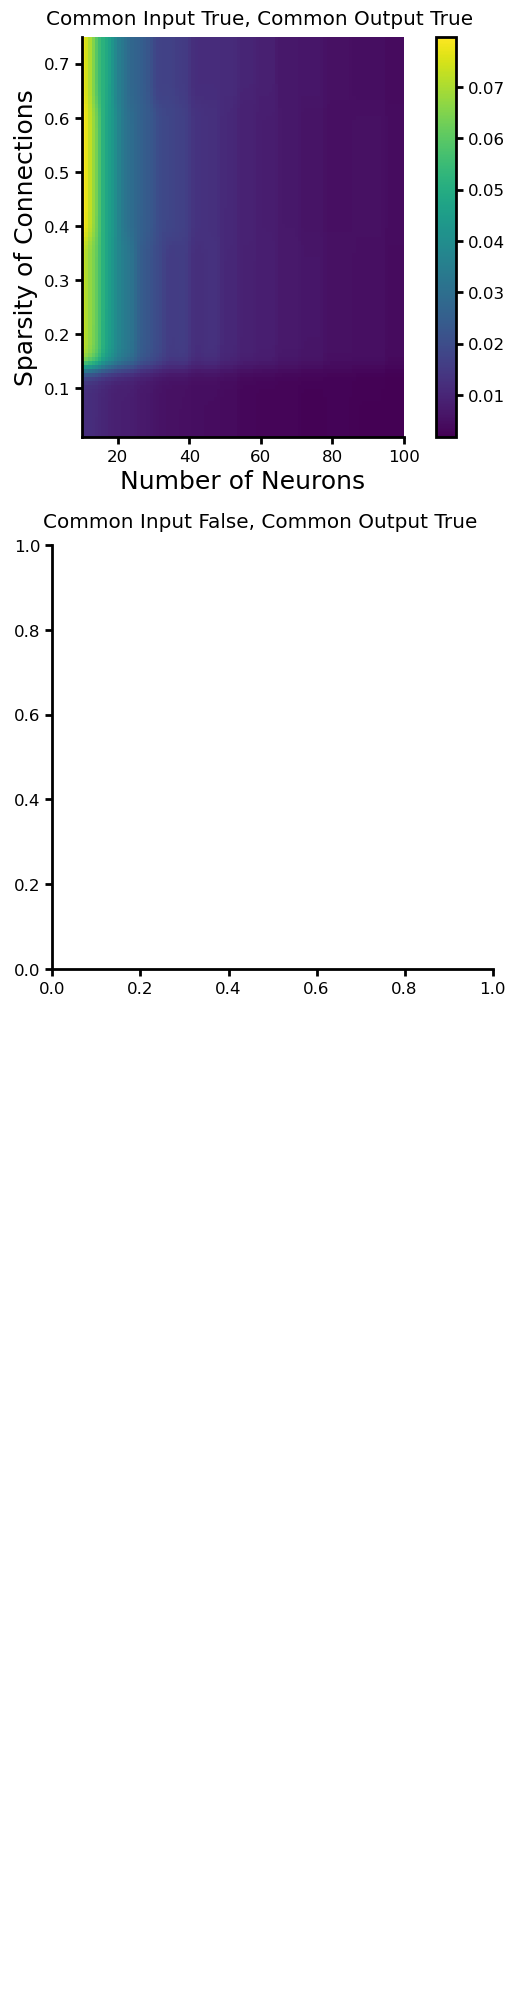

In [12]:
set_style()


plot_type = "heatmap"
log_scale = False

metrics = [
    "retraining_det_col_norm",
    # "correlations_det_col_norm",
    # "ablations_det_col_norm",
]
# metrics = ['mean_global_diff']
# metrics = [
#    "retraining_global_diff",
#    "ablations_global_diff",
#    "correlations_global_diff",
# ]

fig = plt.figure(constrained_layout=True, figsize=(len(metrics) * 5, 5 * 4))
# fig.suptitle('Metrics Slices')
subfigs = fig.subfigures(nrows=4, ncols=1)
try:
    subfigs[0]
except TypeError:
    subfigs = [subfigs]

for m, (subfig, [c_r, c_i]) in enumerate(
    zip(subfigs.flatten(), product([True, False], repeat=2))
):
    # for m, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=len(metrics))
    try:
        axs[0]
    except TypeError:
        axs = [axs]
    for i, ax in enumerate(axs):

        c_data = filter_data(
            total_data,
            {
                "Step": "last",
                "common_input": c_i,
                "common_readout": c_r,
                "n_bot": None,
                "task": ["parity-digits-both", "family"][0],
                "cov_ratio": varying_params["cov_ratio"][:-1],
            },
        )

        if 0 in c_data.shape:
            continue

        subfig.suptitle(f"Common Input {c_i}, Common Output {c_r}")

        c_data = c_data[c_data["sparsity"] != 0]
        print(c_data.shape)

        x = "n_hidden"
        y = "cov_ratio"

        values = get_values(c_data, x, y, metrics[i])
        # values[1] = np.sqrt(values[1])

        if plot_type == "heatmap":

            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_,) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=log_scale,
                plot_f=False,
                random=False,
                smoothness=2,
                minmax=None,
            )

        elif plot_type == "scipy":
            (
                X_mesh,
                Y_mesh,
                Z,
                (fig, ax),
                cbar,
            ) = compute_and_plot_colormesh(values, (fig, ax), log_scale=log_scale)

        ax.set_xlabel(x)
        ax.set_ylabel(y)

        # ax.set_title(metrics[i])

        ax.set_ylabel("Sparsity of Connections")
        # ax.set_yticklabels(ax.get_yticklabels()[::-1])
        ax.set_xlabel("Number of Neurons")

(25180, 37)
(23830, 37)


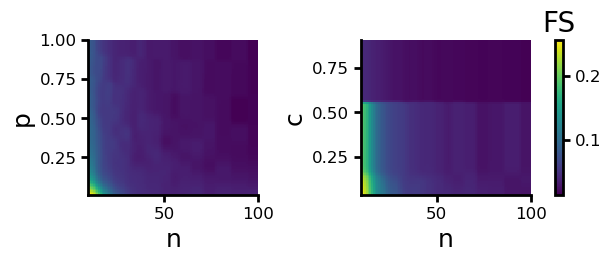

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), constrained_layout=True)
plot_type = "heatmap"
c_data = filter_data(
    total_data,
    {
        "Step": "last",
        "common_input": False,
        "common_readout": False,
        "n_bot": None,
        "task": ["parity-digits-both", "family"][0],
        "cov_ratio": varying_params["cov_ratio"][:-1],
    },
)

print(c_data.shape)
assert 0 not in c_data.shape

c_data = c_data[c_data["sparsity"] != 0]
print(c_data.shape)

x = "n_hidden"

for m, (ax, y) in enumerate(zip(axs, ["sparsity", "covariance"])):

    values = get_values(c_data, x, y, metrics[0])
    # values[1] = np.sqrt(values[1])

    if plot_type == "heatmap":

        ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
            values,
            (fig, ax),
            log_scale=log_scale,
            plot_f=False,
            random=False,
            smoothness=2.5,
            minmax=None,
            cbar=m != 0,
        )

    elif plot_type == "scipy":
        (X_mesh, Y_mesh, Z, (fig, ax), cbar,) = compute_and_plot_colormesh(
            values, (fig, ax), log_scale=log_scale, cbar=m != 0
        )

    ax.set_xlabel(x)
    ax.set_ylabel(y)

    # ax.set_title(metrics[i])

    if y == "sparsity":
        ax.set_ylabel("p")
    elif y == "covariance":
        ax.set_ylabel("c")
    # ax.set_yticklabels(ax.get_yticklabels()[::-1])
    ax.set_xlabel("n")
    try : 
        cbar.set_label('FS')
    except AttributeError : 
        pass

In [21]:
varying_params["cov_ratio"]

[0.01, 0.26, 0.5, 0.75, 1.0]

In [37]:
[estimate_covariance(c, 10) for c in varying_params["cov_ratio"]]

[0.9088479652197782,
 0.21595696364100525,
 0.07999505951266446,
 0.02742507930566604,
 -0.000255519816973002]

In [89]:
fig.savefig("../../results/imgs/heatmaps.svg")


### Q Metric

In [92]:
uniques = sorted(total_data["n_hidden"].unique().tolist())

In [94]:
c_data = filter_data(
    total_data,
    {
        "Step": "last",
        "common_input": False,
        "common_readout": False,
        # "n_bot": 5,
        # "task": "family",
        #"n_hidden": [49],
        "cov_ratio": 0.75,
    },
)
c_data.shape

(7390, 37)

In [95]:
c_data[c_data["sparsity"] == 0]["best_acc"].mean()

0.5672439

In [ ]:
((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
            values,
            (fig, ax),
            log_scale=log_scale,
            plot_f=False,
            random=False,
            smoothness=2.5,
            minmax=None,
            cbar=m != 0,
        )

In [43]:
metrics = [
    "retraining_global_diff",
    "ablations_global_diff",
    "correlations_global_diff",
]

plot_data = {"q_metric": [], "metric_value": [], "metric_name": []}

for metric in metrics:
    plot_data["metric_value"].append(c_data[metric])
    plot_data["q_metric"].append(c_data["q_metric"])
    plot_data["metric_name"].append(np.full(len(c_data), metric, dtype=object))

plot_data = pd.DataFrame.from_dict({k: np.concatenate(v) for k, v in plot_data.items()})

In [67]:
uniques[-8:]


[51, 56, 61, 68, 74, 82, 90, 100]

(200, 37)
(200, 37)
(200, 37)
(200, 37)


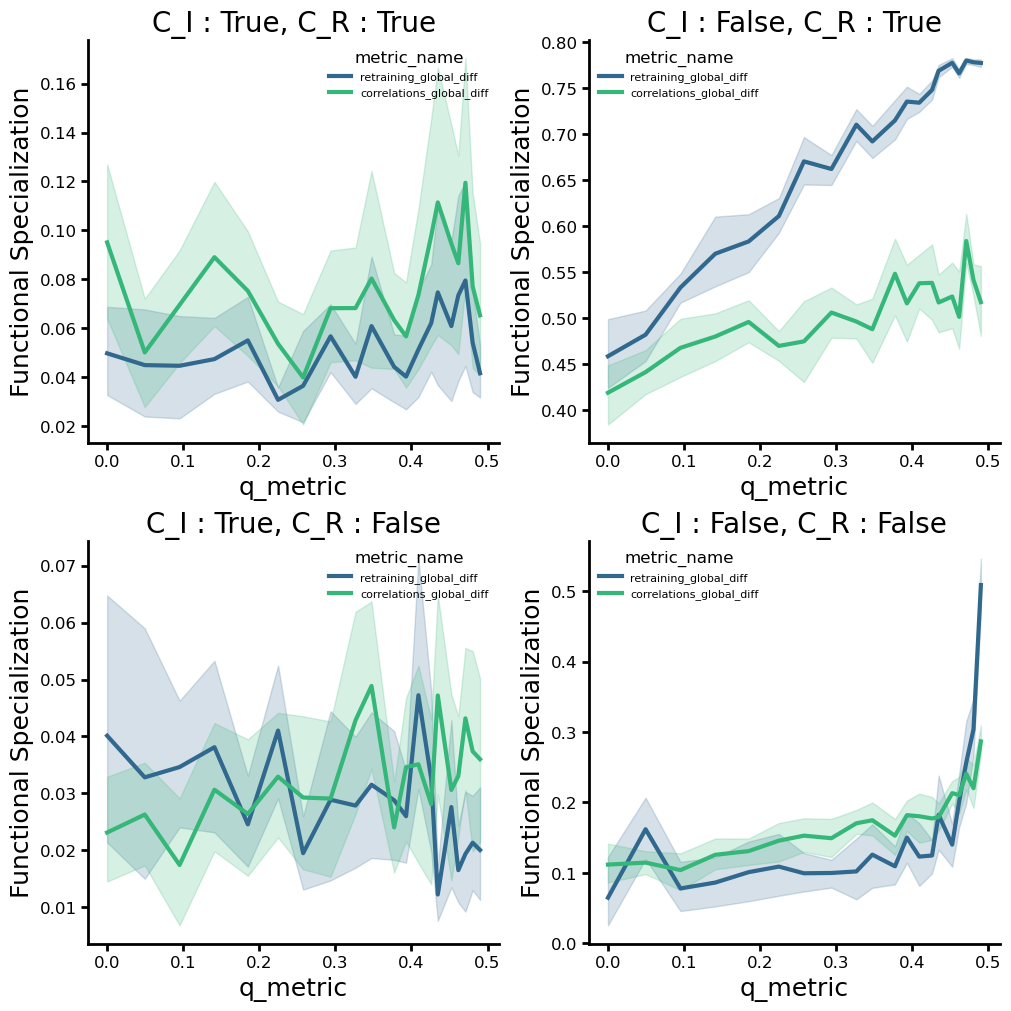

In [76]:
set_style()

smooth = True


fig, axs = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

for ax, [c_r, c_i] in zip(axs.flatten(), product([True, False], repeat=2)):

    c_data = filter_data(
        total_data,
        {
            "Step": "last",
            "common_input": c_i,
            "common_readout": c_r,
            "n_bot": None,
            "task": "parity-digits-both",
            #"n_hidden": 16,
            "cov_ratio": 0.75,
        },
    )
    c_data = c_data[c_data["sparsity"] != 0]
    print(c_data.shape)

    metrics = [
        "retraining_global_diff",
        # "ablations_global_diff",
        "correlations_global_diff",
    ]

    # metrics = ['mean_global_diff']

    keys = [
        "metric_value",
        "metric_name",
        "sparsity",
        "n_hidden",
        "q_metric",
        "n_conns",
    ]
    plot_data = {k: [] for k in keys}
    smooth_data = {k : [] for k in keys[:2]}

    x = "q_metric"

    for metric in metrics:
        plot_data["metric_value"].append(c_data[metric])
        plot_data["metric_name"].append(np.full(len(c_data), metric, dtype=object))
        
        values = get_values(c_data, x, 'n_hidden' metric)

        if smooth : 
                
            ((X, Y), (X_mesh, Y_mesh), Z, sigmas, *_, cbar) = compute_and_plot_heatmap(
                values,
                (fig, ax),
                log_scale=log_scale,
                plot_f=False,
                random=False,
                smoothness=2.5,
                minmax=None,
                cbar=m != 0,
                plot=False
            )

            smooth_data["metric_value"].append(Z.mean(1))
            smooth_data["metric_name"].append(np.full(len(c_data), metric, dtype=object))
            smooth_data.setdefault(x, [])
            smooth_data[x].append(X)


        for k in keys[2:]:
            plot_data[k].append(c_data[k])

    plot_data = pd.DataFrame.from_dict(
        {k: np.concatenate(v) for k, v in plot_data.items()}
    )

    smooth_data = pd.DataFrame.from_dict(
        {k: np.concatenate(v) for k, v in plot_data.items()}
    )


    sns.lineplot(
        data=plot_data,
        x=x,
        y="metric_value",
        hue="metric_name",
        ax=ax,
        palette="viridis",
        estimator="mean",
    )

    # ax.set_yscale('log')
    ax.set_ylabel("Functional Specialization")
    ax.set_xlabel(x)
    if x == "sparsity":
        pass
        # ax.set_xscale("log")
    ax.set_title(f"C_I : {c_i}, C_R : {c_r}")

In [100]:
X

array([ 10.        ,  10.90909091,  11.81818182,  12.72727273,
        13.63636364,  14.54545455,  15.45454545,  16.36363636,
        17.27272727,  18.18181818,  19.09090909,  20.        ,
        20.90909091,  21.81818182,  22.72727273,  23.63636364,
        24.54545455,  25.45454545,  26.36363636,  27.27272727,
        28.18181818,  29.09090909,  30.        ,  30.90909091,
        31.81818182,  32.72727273,  33.63636364,  34.54545455,
        35.45454545,  36.36363636,  37.27272727,  38.18181818,
        39.09090909,  40.        ,  40.90909091,  41.81818182,
        42.72727273,  43.63636364,  44.54545455,  45.45454545,
        46.36363636,  47.27272727,  48.18181818,  49.09090909,
        50.        ,  50.90909091,  51.81818182,  52.72727273,
        53.63636364,  54.54545455,  55.45454545,  56.36363636,
        57.27272727,  58.18181818,  59.09090909,  60.        ,
        60.90909091,  61.81818182,  62.72727273,  63.63636364,
        64.54545455,  65.45454545,  66.36363636,  67.27

In [66]:
from scipy.stats import gaussian_kde


In [384]:
fig.savefig("../../results/imgs/q_metric.svg")


### Spec Gradient

In [58]:
uniques


[10,
 11,
 12,
 13,
 14,
 16,
 17,
 19,
 21,
 23,
 26,
 28,
 31,
 34,
 38,
 42,
 46,
 51,
 56,
 61,
 68,
 74,
 82,
 90,
 100]

In [59]:
c_data = filter_data(
    total_data,
    {
        "common_input": False,
        "common_readout": True,
        "n_bot": None,
        "task": "parity-digits-both",
        "cov_ratio": 0.75,
        "n_hidden": [38, 42, 46],
    },
)
print(c_data.shape)

c_data = c_data[c_data["sparsity"] != 0]

(2100, 35)


In [60]:
steps = c_data["Step"].unique().tolist()
agents = ["0", "1", "all"]
agents = [agents[0]] * len(steps) + [agents[-1]] + [agents[1]] * len(steps)
all_steps = steps + [steps[-1]] + steps[::-1]

ts = np.arange(len(steps))
ts = np.concatenate((ts, np.array([-1]), np.flip(ts)))
ags = np.concatenate(
    (np.zeros(len(steps)), np.array([-1]), np.ones(len(steps)))
).astype(int)


In [61]:
plot_data = {k: [] for k in ["x", "ag", "step", "metric", "sparsity", "n_conns"]}

for x, (step, ag) in enumerate(zip(all_steps, agents)):

    metric = c_data[c_data["Step"] == step][f"retraining_{ag}_local_diff"]
    plot_data["x"].append(np.full_like(metric, x, dtype=int))
    plot_data["step"].append(np.full_like(metric, step, dtype=object))
    plot_data["ag"].append(np.full_like(metric, ag, dtype=object))
    plot_data["metric"].append(metric)
    plot_data["sparsity"].append(c_data[c_data["Step"] == step]["sparsity"])
    plot_data["n_conns"].append(c_data[c_data["Step"] == step]["n_conns"])

plot_data = pd.DataFrame.from_dict({k: np.concatenate(v) for k, v in plot_data.items()})
local_diffs = [
    c_data[c_data["Step"] == s][f"retraining_{ag}_local_diff"]
    for s, ag in zip(steps, ags)
]


/tmp/ipykernel_113730/83384482.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = ax.figure.colorbar(sm, orientation="vertical")


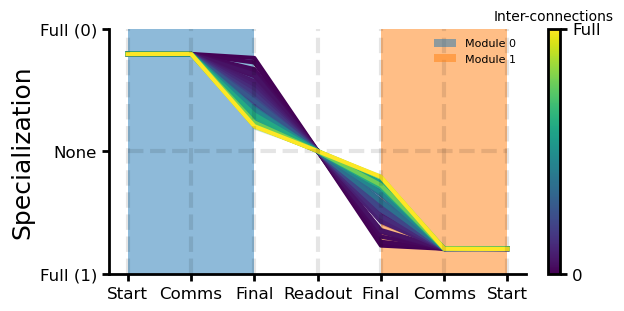

In [63]:
fig, ax = plt.subplots(figsize=(6, 3), constrained_layout=True)
sns.lineplot(
    plot_data, x="x", y="metric", hue="sparsity", palette="viridis", ax=ax, legend=False
)
x = plot_data["x"].unique()

steps_label = ["Start", "Comms", "Final"]
x_labels = [f"{steps_label[t]}" for t in ts]
x_labels[len(steps)] = "Readout"
ax.set_xticks(x)
ax.set_xticklabels(labels=x_labels)
ax.set_ylim(-1, 1)
ax.set_ylabel("Specialization")
ax.set_yticks([-1, 0, 1], ["Full (1)", "None", "Full (0)"])
ax.hlines(0, x[0], x[-1], linestyles="--", colors="black", alpha=0.1)
ax.vlines(x, -1, 1, linestyles="--", colors="black", alpha=0.1)
ax.fill_betweenx(
    [-len(steps), len(steps)], 0, len(steps) - 1, alpha=0.5, label="Module 0"
)
ax.fill_betweenx(
    [-len(steps), len(steps)], len(steps) + 1, x[-1], alpha=0.5, label="Module 1"
)
ax.set_xlabel("")
ax.legend()

sm = plt.cm.ScalarMappable(cmap="viridis")
sm.set_array([])
cb = ax.figure.colorbar(sm, orientation="vertical")
cb.set_label("Inter-connections", fontsize="small")
cb.set_ticks([0, 1], labels=["0", "Full"])


In [64]:
fig.savefig("../../results/imgs/gradient.svg")


### Parameter Importance

In [65]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, plot_tree

In [77]:
params = [
    "common_readout",
    "n_bot",
    "common_input",
    "task",
    "Step",
    "cov_ratio",
    "n_hidden",
    "sparsity",
]

varying_params = {}
for param in params:
    if param in total_data.columns:
        varying_params[param] = total_data[param].unique().tolist()
        try:
            varying_params[param] = sorted(varying_params[param])
            varying_params[param] = [
                v if not np.isnan(v) else None for v in varying_params[param]
            ]
        except TypeError:
            pass

rf = RF()
metric = metrics[0]
# metric = "best_acc"

all_features = [k for k, v in varying_params.items() if len(v) > 1]

fixed_features = {k: v for k, v in varying_params.items() if len(v) == 1}
fixed_features.update(
    {"Step": "last", "n_bot": None, "task": "parity-digits-both", "cov_ratio": 0.75}
)

data = total_data
remaining_features = [f for f in all_features if f not in fixed_features]

data = filter_data(data, fixed_features)

X = data[remaining_features]
y = data[metric]

if "task" in remaining_features:
    X["task_bool"] = X["task"] == "family"
    X = X[[f for f in remaining_features if f != "task"] + ["task_bool"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf.fit(X_train, y_train)

print(np.abs((rf.predict(X_test) - y_test)).mean())

feature_importances = lambda rf: {
    f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)
}

0.027045994822610126


In [73]:
fixed_features


{'Step': 'last', 'n_bot': None}

Text(0, 0.5, 'Feature Importance')

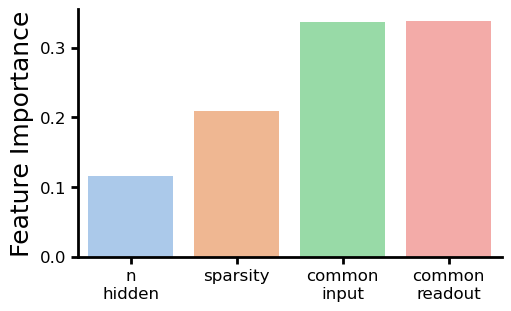

In [78]:
set_style()
plot_data = {}
plot_data["feature"] = [k.replace("_", "\n") for k in feature_importances(rf).keys()]
plot_data["importance"] = list(feature_importances(rf).values())
plot_data = pd.DataFrame.from_dict(plot_data)

fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
sns.barplot(
    plot_data.sort_values(by="importance"),
    x="feature",
    y="importance",
    ax=ax,
    palette="pastel",
)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance")


In [531]:
fig.savefig("../../results/imgs/feature_importance.svg")


## Tables

In [36]:
x, y, metric = *heatmap_params[::2], "retraining_global_diff"

In [40]:
data = filter_data(total_data, {"Step": "last", "common_input": False})


In [62]:
x_values = data[x].unique()[::-1]
y_values = data[y].unique()
y_values_per_x = data.groupby(x)[y].unique()
grouped_values = data.groupby([x, y])[metric].mean()

z_dict = [
    {(xv, yv): grouped_values[xv][yv] for yv in y_values_per_x[xv]} for xv in x_values
]

In [68]:
z = pd.concat([grouped_values[x] for x in x_values], axis=1)
z.columns = x_values
z = z[sorted(x_values)]


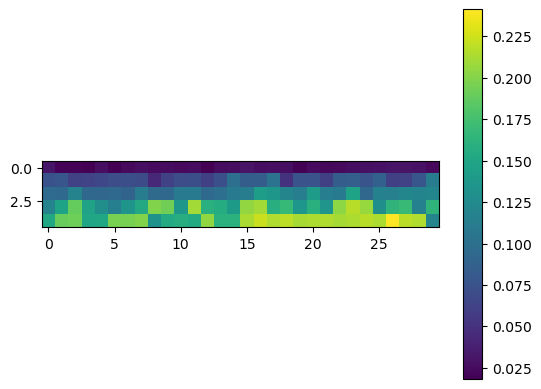

In [72]:
import seaborn as sns

plt.imshow(z, data=z)
plt.colorbar()


In [47]:
x_values

array([ 68,  37,  34, 100,  47,  13,  44,  16,  31,  96,  10,  59,  90,
        41,  93,  25,  78,  50,  22,  81,  87,  84,  56,  65,  19,  62,
        72,  28,  53,  75])

In [142]:
y_values_per_x


n_hidden
10          [1.0, 0.75, 0.5, 0.25]
25          [1.0, 0.75, 0.5, 0.25]
50          [1.0, 0.75, 0.5, 0.25]
75     [1.0, 0.75, 0.5, 0.25, 0.0]
100    [1.0, 0.75, 0.5, 0.25, 0.0]
Name: cov_ratio, dtype: object

### Specialization Gradient

In [15]:
def get_spec_gradient(**v_params):

    if v_params["n_hidden"] not in total_data["n_hidden"].unique():
        return

    v_params.pop("Step")
    print(v_params)
    ags = ["Ag 0", "Readout", "Ag 1"]
    data = filter_data(total_data, v_params)
    data_per_ts = [filter_data(data, {"Step": ts}) for ts in ["mid-", "last"]]
    data_per_ag_mean = [
        [data[[f"bottleneck_{ag}_local_diff"]] for ag in [0, "all", 1]]
        for data in data_per_ts
    ]

    diffs_ag_ts = {
        f"{ags[j]} ts {i}": data_per_ag_mean[i][j].values.squeeze()
        for i, j in [[0, 0], [1, 0], [1, 1], [1, 2], [0, 2]]
    }

    diffs_ag_ts = pd.DataFrame.from_dict(diffs_ag_ts)
    diffs_ag_ts["sparsity"] = data_per_ts[0]["sparsity"].values.squeeze()

    fig, ax = plt.subplots(figsize=(10, 5), dpi=100, constrained_layout=True)
    plot_data = data = diffs_ag_ts.groupby("sparsity").mean()
    colors = sns.color_palette(
        "husl", n_colors=len(plot_data.index.values)
    )  # get a number of colors
    cmap = dict(zip(plot_data.index.values, colors))  # zip values to colors
    plot = sns.lineplot(plot_data.T, legend=False, palette=cmap, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=sns.husl_palette(as_cmap=True))
    sm.set_array([])
    fig.colorbar(sm, label="% interconnections", orientation="vertical", ax=ax)

    ax.set_xticklabels(
        [
            f"{ 'Ag' * (ag != 'Readout')} {ag} Step {t}"
            for t, ag in [[0, 0], [1, 0], [1, "Readout"], [1, 1], [0, 1]]
        ]
    )
    ax.set_ylim(-1, 1)
    ax.set_ylabel("Functional \n Specialization")
    ax.set_yticks([-1, 0, 1], ["Subtask 1", "No Spec", "Subtask 0"])

    ax.hlines(0, 0, 4, linestyles="--", colors="black", alpha=0.3)
    ax.vlines(np.arange(5), -1, 1, linestyles="--", colors="black", alpha=0.3)

    fig.show()

In [16]:
params_widgets = {
    k: widgets.Select(
        options=[p for p in params], description=k, disabled=False, value=params[0]
    )
    for k, params in varying_params.items()
}

params_widgets["n_hidden"] = widgets.IntSlider(value=25, min=10, max=100, step=5)

interactive_plot = widgets.interactive(get_spec_gradient, **params_widgets)

display(interactive_plot)

interactive(children=(Select(description='common_readout', options=(True,), value=True), Select(description='n…

In [230]:
{params[0] for k, params in varying_params.items()}

{5, False, True, 'mid-', 'parity-digits'}

### Parameter Importance

In [136]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, plot_tree

In [140]:
[k for k, v in varying_params.items() if len(v) > 1]

['common_readout', 'n_bot', 'common_input', 'Step', 'cov_ratio']

In [149]:
params = [
    "common_readout",
    "n_bot",
    "common_input",
    "task",
    "Step",
    "cov_ratio",
    "n_hidden",
    "sparsity",
]

varying_params = {}
for param in params:
    if param in total_data.columns:
        varying_params[param] = total_data[param].unique().tolist()
        try:
            varying_params[param] = sorted(varying_params[param])
            varying_params[param] = [
                v if not np.isnan(v) else None for v in varying_params[param]
            ]
        except TypeError:
            pass

rf = RF()
metric = metrics[0]
# metric = "best_acc"

all_features = [k for k, v in varying_params.items() if len(v) > 1]

fixed_features = {k: v for k, v in varying_params.items() if len(v) == 1}

fixed_features.update({"Step": "last", "n_bot": 5})

data = total_data
remaining_features = [f for f in all_features if f not in fixed_features]

data = filter_data(data, fixed_features)

X = data[remaining_features]
y = data[metric]

if "task" in remaining_features:
    X["task_bool"] = X["task"] == "all"
    X = X[[f for f in remaining_features if f != "task"] + ["task_bool"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rf.fit(X_train, y_train)

print(np.abs((rf.predict(X_test) - y_test)).mean())

feature_importances = lambda rf: {
    f: f_i for f, f_i in zip(rf.feature_names_in_, rf.feature_importances_)
}


0.03846413042899654


In [150]:
feature_importances(rf)

{'common_readout': 0.08835830398627519,
 'common_input': 0.11556805494836744,
 'cov_ratio': 0.24013192899714103,
 'n_hidden': 0.10968919700068862,
 'sparsity': 0.4462525150675277}

Text(0, 0.5, 'Feature Importance')

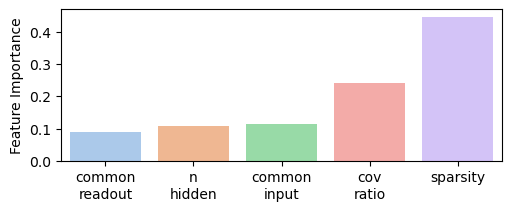

In [174]:
plot_data = {}
plot_data["feature"] = [k.replace("_", "\n") for k in feature_importances(rf).keys()]
plot_data["importance"] = list(feature_importances(rf).values())
plot_data = pd.DataFrame.from_dict(plot_data)

fig, ax = plt.subplots(figsize=(5, 2), constrained_layout=True)
sns.barplot(
    plot_data.sort_values(by="importance"),
    x="feature",
    y="importance",
    ax=ax,
    palette="pastel",
)
ax.set_xlabel("")
ax.set_ylabel("Feature Importance")


In [176]:
5

2.5

In [175]:
fig.savefig("../../results/imgs/feature_importance.svg")


# Find new metric

In [2]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import LinAlgError


In [8]:
def agent_diff(col):
    return (col[1] - col[0]) / col.sum()


def global_diff(M):
    return np.abs(agent_diff(M[:, 0]) - agent_diff(M[:, 1])) / 2


def new_metric(M):
    return np.abs(LA.det(M)) / M.sum(0).prod()

In [29]:
n_agents = 2

M = np.random.rand(n_agents, n_agents)

M = np.eye(n_agents)
M[0, 1] = 1

new_metric(M), np.abs(LA.det(M))


(0.5, 1.0)

In [128]:
idxs = [0, 2]
sub_mat = lambda M, idx: np.delete(np.delete(M, idx[0], 0), idx[1], 1).squeeze()
sub_mat(M, idxs), M

(array([[0., 1.],
        [0., 0.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [180]:
def reccursive_new_metric(M):
    if M.shape[0] > 2:

        res = new_metric(M)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                subM = sub_mat(M, [i, j])
                res += reccursive_new_metric(subM)

    else:
        res = new_metric(M)

    print(res)
    return res